In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from lsst.sims.maf.metrics.snCadenceMetric import SNcadenceMetric
from lsst.sims.maf.utils.snUtils import Lims

## DB file choice

In [2]:
dbName = 'kraken_2026.db'
dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion
propinfo, proptags = opsimdb.fetchPropInfo()
print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

proptags and propinfo {'WFD': [3], 'DD': [5], 'NES': [4]} {1: 'GalacticPlane', 2: 'SouthCelestialPole', 3: 'WideFastDeep', 4: 'NorthEclipticSpur', 5: 'DeepDrillingCosmology1'}


## Field choice (DD or WFD)

In [3]:
fieldtype='WFD' #fieldtype: DD or WFD

sqlconstraint = opsimdb.createSQLWhere(fieldtype, proptags)


if fieldtype == 'DD':
    SNR = dict(zip('griz', [25., 25., 30., 35.]))  # SNR for DD
    mag_range = [23., 27.5]  # DD mag range
    dt_range = [0.5, 25.]  # DD dt range
    coadd = True
    zmin = 0.4
    zmax = 0.7
if fieldtype == 'WFD':
    SNR = dict(zip('griz', [30., 40., 30., 20.]))  # SNR for WFD
    mag_range = [21., 25.5]  # WFD mag range
    dt_range = [0.5, 30.]  # WFD dt range
    coadd = False
    zmin = 0.1
    zmax = 0.6
    
Li_files = ['../../data/Li_SNCosmo_-2.0_0.2.npy']
mag_to_flux_files = ['../../data/Mag_to_Flux_SNCosmo.npy']

In [4]:
yearDates = list(range(0, int(round(365 * runLength)) + 365, 365))
bands = 'r'
    # for i, band in enumerate(SNR.keys()):
plotDict = {'title': 'Redshift limit',
                'xlabel': 'z','xMin':zmin,'xMax':zmax,'nTicks':10,
           'colorMin': zmin,'colorMax':zmax}

plotDict['bins'] = np.arange(0.,0.5,0.05)

print(yearDates)
yearDates = yearDates[:3]

# Load sn lc info and mags
lim_sn = {}
for band in bands:
     lim_sn[band] = Lims(Li_files, mag_to_flux_files, band, SNR[band],
                          mag_range=mag_range, dt_range=dt_range)

[0, 365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650]


## Define slicer

In [5]:
from lsst.sims.utils import equatorialFromGalactic
names = ['ra', 'dec']
# Number of objects to create
nobjs = int(1e4)  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
# An empty numpy array that will hold the catalog of transient objects
transObjects = np.zeros(nobjs, dtype=list(zip(names, [float]*len(names))))
# Concentrate objects in the galactic plane
l = np.random.rand(nobjs)*360.
b = np.random.randn(nobjs)*20.
transObjects['ra'], transObjects['dec'] = equatorialFromGalactic(l,b)
# Set up the slicer to evaluate the catalog we just made
# XXX--ugh, because the old V3 OpSim runs store things in radians, need to set latLonDeg kwarg. 
slicer = slicers.UserPointsSlicer(transObjects['ra'], transObjects['dec'], latLonDeg=True)
#slicer = slicers.HealpixSlicer(nside=64)

## Make the bundles

In [6]:
bundleList= []
for band in bands: #Loop on the bands
    sql_i = sqlconstraint+' AND '
    sql_i += 'filter = "%s"' % (band) #sql constraint on the band
    
    metric = SNcadenceMetric(lim_sn=lim_sn[band], coadd=coadd)
    
    for i in range(len(yearDates) - 1):
        sql_y = sql_i + \
            ' AND night > %i AND night <= %i' % (
                yearDates[i], yearDates[i + 1]) #sql constraint on the year
        plotDict['title'] = 'Y{} - {} band'.format(i+1,band)
            
        bundleList.append(metricBundles.MetricBundle(
            metric, slicer, sql_y, runName= dbName,plotDict=plotDict))
print(len(bundleList))

2


In [7]:
outDir = '{}_Cadence'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint proposalId = 3 AND filter = "r" AND night > 0 AND night <= 365 for columns ['fieldRA', 'observationId', 'fiveSigmaDepth', 'fieldDec', 'night', 'observationStartMJD', 'visitTime', 'numExposures', 'filter', 'visitExposureTime']
Found 34958 visits
Running:  ['kraken_2026_db_SNCadenceMetric_proposalId_3_AND_r_AND_night_gt_0_AND_night_lt_365_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 3 AND filter = "r" AND night > 365 AND night <= 730 for columns ['fieldRA', 'observationId', 'fiveSigmaDepth', 'fieldDec', 'night', 'observationStartMJD', 'visitTime', 'numExposures', 'filter', 'visitExposureTime']
Found 42650 visits
Running:  ['kraken_2026_db_SNCadenceMetric_proposalId_3_AND_r_AND_night_gt_365_AND_night_lt_730_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "proposalId = 3 AND filter = "r" AND night > 365 AND night <= 730" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_2_8_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


Plotting complete.
Plotting figures with "proposalId = 3 AND filter = "r" AND night > 0 AND night <= 365" constraint now.
Plotting complete.


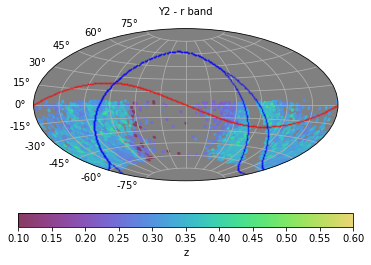

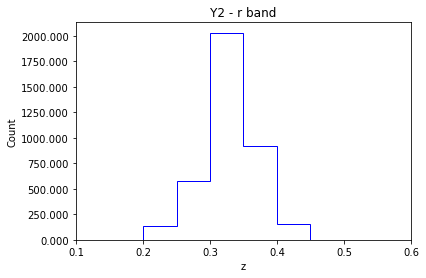

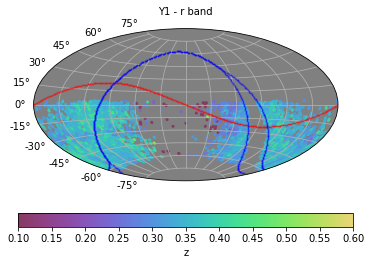

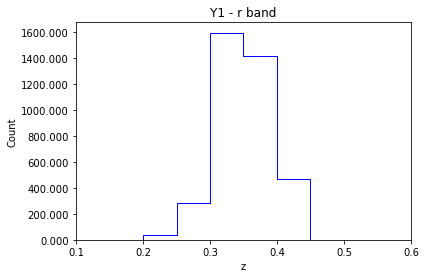

In [8]:
bgroup.plotAll(closefigs=False)